# Introduction

In today's North America, mortgage has become a major financial method homebuyers employ to afford new homes. From a data scientist's perspective, I am interested in the information that the backgrounds of mortgage applications can provide us, and also I feel curious about the factors that may affect the performance of repayment of a mortgage.  

In this analysis study, I was using the November 2019 release of the Single Family Loan-Level Dataset from Freddie Mac, a mortgage loaner in the United States. The dataset contains the information of the mortgages originated from January 1, 1999 through September 30, 2018, with monthly
loan performance data through March 31, 2019, that were sold to Freddie Mac or that back Freddie Mac Participation Certificates (PCs). The dataset is divided into two sections: the Origination Dataset and the Monthly Performance Dataset. Throughout the analysis, I will be using both sets included in the dataset to answer a number of question regarded to mortgage origination backgrounds as well as payment performances. 

This project was inspired by Senso.ai of Toronto. The firm also contributed to the project by introducing me to the dataset. 

In [1]:
# Import the needed packages
import numpy as np
import pandas as pd
import scipy
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from six import StringIO
import pydotplus

# Analysis on the Origination Dataset

The Origination dataset contains the information of the recorded mortgages at Freddie Mac, at the time the mortgage was initialized. It represents mainly the general backgrounds of the mortgages, which may provide us with (but not limited to) the price and area of the property secured by the mortgage, and financial background and history of the individual, and the channels that initialized the purchase and the mortgage. 

In [2]:
# Read the origination samples csv file
origination_data = pd.read_csv("origination_sample.csv")

## First-time Homebuyers

In the Origination database, the first-time homebuyers are identified by a specific flag. In real life, they may be eligible of designated policies, offers and/or credits, either from the government or financial institutions. From the mortgage provider's perspective, we want to see the structure of all homebuyers in the database, and figure out the role of first-time homebuyers within other buyers. 

On the first rough glimpse, I computed the percentage of first-buyers among all buyers of all times as presented in the database. 

In [3]:
# Percentage of first time homebuyers
first_time_data = origination_data.groupby("first_time_homebuyer_flag")
first_buyer = first_time_data.size()["Y"]
non_first_buyer = first_time_data.size()["N"]
first_buyer / (first_buyer + non_first_buyer)

0.16807615740394258

As the computation above suggests, it turns out that 16.8076% of all homebuyers are categorized as first-time homebuyers at all times according to the provided database. 

To further analyse the number, portion and role of first-time homebuyers, I made further computations to find the relationship between portion of first-time homebuyers and the month, while comparing this relationship to that between the number of all homebuyers and the month. 

In [4]:
# Percentage of first time homebuyers in each month
new_origination_data = origination_data.copy()
new_origination_data["month"] = origination_data["first_payment_date"] % 100
month_firsthome_data = new_origination_data.loc[:, ["month", "first_time_homebuyer_flag"]]
month_firsthome_data = month_firsthome_data[month_firsthome_data["first_time_homebuyer_flag"] != "9"]

month_firsthome_count = month_firsthome_data.groupby(
    ["month", "first_time_homebuyer_flag"]
).size()

# Compute ft_monthly_percentage

ft_monthly_percentage = np.array([np.nan] * 12)
total_array = np.array([np.nan] * 12)

total_first_time = np.array([np.nan] * 12)

for month in range(1, 13): 
    first_buyer = month_firsthome_count[month]["Y"]
    non_first_buyer = month_firsthome_count[month]["N"]
    total_array[month - 1] = first_buyer + non_first_buyer
    ft_monthly_percentage[month - 1] = first_buyer / total_array[month - 1]
    total_first_time[month - 1] = first_buyer

# Compute ft_annual_percentage 
ft_annual_percentage = np.array(
    [month / sum(total_first_time) for month in total_first_time]
)

# Compute homebuyer_percentage
homebuyer_percentage = np.array(
    [month / sum(total_array) for month in total_array]
)

percentage_table = pd.DataFrame({
    "month": [month for month in range(1, 13)], 
    "total_first_time": total_first_time,
    "total_buyers": total_array,
    "ft_monthly_percentage": ft_monthly_percentage,
    "ft_annual_percentage": ft_annual_percentage,
    "homebuyer_percentage": homebuyer_percentage,
})
percentage_table

,month,total_first_time,total_buyers,ft_monthly_percentage,ft_annual_percentage,homebuyer_percentage
0,1,849.0,5066.0,0.167588,0.075608,0.075828
1,2,862.0,4811.0,0.179173,0.076766,0.072011
2,3,579.0,4457.0,0.129908,0.051563,0.066713
3,4,702.0,5086.0,0.138026,0.062517,0.076127
4,5,812.0,5895.0,0.137744,0.072313,0.088237
5,6,1000.0,5922.0,0.168862,0.089055,0.088641
6,7,1095.0,6085.0,0.179951,0.097515,0.091081
7,8,1228.0,6463.0,0.190005,0.109360,0.096738
8,9,1148.0,6169.0,0.186092,0.102235,0.092338
9,10,1069.0,5824.0,0.183551,0.095200,0.087174


In the data frame above, I listed the numbers of first-time homebuyers and all homebuyers occurring in each of the 12 months. With the data, I computed for each month: 

- `ft_monthly_percentage`, the percentage of first-time homebuyers among all homebuyers within the month,
- `ft_annual_percentage`, the percentage of first-time homebuyers occuring in the particular month among all first-time homebuyers recorded in the dataset, and
- `homebuyer_percentage`, the percentage of homebuyers (including both first-time and non-first-time ones) occuring in the particular month among all homebuyers recorded in the dataset

To benefit the interpretation of the computed percentages, I visualized them in a scatterplot, as shown below: 

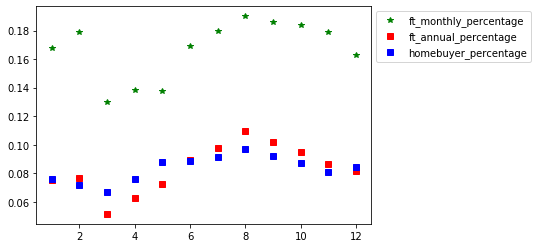

In [5]:
# Plot between first_time_homebuyer_percentage and percentage_annual
month_array = [month for month in range(1, 13)]

plt.plot(month_array, ft_monthly_percentage, 'g*', label="ft_monthly_percentage")
plt.plot(month_array, ft_annual_percentage, 'rs', label="ft_annual_percentage")
plt.plot(month_array, homebuyer_percentage, 'bs', label="homebuyer_percentage")

plt.legend(bbox_to_anchor=(1, 1))
plt.show()

From the data, we may find that the peak for first-time homebuyers within a year is August, while the minimum is observed in March. These also matches the observations for general homebuyers. However, the internal monthly distribution also tends to find the same pattern. Hence we may conclude that while all homebuyers perfer summer and fall seasons for home purchases than winter and spring, the tendency appears to be more obvious and dramatic for first-time homebuyers. 

A possible interpretation of the observation to the real life may be that the period from late spring to summer (May to June) sees the climb of home purchases, and thus becomes preferably the best season of the year for real estate related businesses to attract new homebuyers that will likely make their first home purchase. 

## Metropolitan Statistical Areas (MSA) with High Original Unpaid Pricipal Balances (UPB)

As the dataset represents mortgage records in the United States, the geographical locations are designated to Metropolitan Statistical Areas (MSA) defined by the United States Office of Management and Budget (OMB). 

In this part, we will look into the 10 MSA's which have the highest median original Unpaid Principal Balance (UPB) upon the opening of the mortgage, and attempt to find explain the nature of their high pricipal balances. 

In [6]:
# MSA's with the highest median original unpaid principal balance
new_origination_data2 = origination_data.copy()

msa_upb_data = new_origination_data2.loc[:, ['msa', 'original_upb', 'original_ltv']]
upb_data = pd.DataFrame(
    msa_upb_data.groupby('msa').median()
)
highest_upb = upb_data.sort_values(by='original_upb', ascending=False).head(n=10)

highest_upb['original_ltv_percentile'] = np.array(
    [scipy.stats.percentileofscore(msa_upb_data.loc[:, 'original_ltv'], ltv) 
     for ltv in np.array(highest_upb['original_ltv'])
    ]
)
    
highest_upb

,original_upb,original_ltv,original_ltv_percentile
msa,,,
42034.0,414000.0,59.0,20.636676
11244.0,364000.0,65.0,27.771634
27980.0,347000.0,54.0,15.795062
42200.0,338000.0,57.0,18.634464
41884.0,330000.0,50.0,12.425749
41940.0,324000.0,55.0,16.709073
46520.0,316000.0,66.0,29.159286
43524.0,288000.0,72.5,40.033468
36084.0,285000.0,64.0,26.400129


The data frame above shows the codes for the 10 MSA's with the highest original UPB's, as well as the UPB's exact values. However, the reason that could lead to the high UPB's in these areas is not determined.

There are two possible assumption to explain the high original UPB values: it is possible that the price of homes in these areas are higher and the buyers are generally richer, but it is also possible that the high ratio of debt for buyers in these regions lead to the high balances. To determine the true nature, we will be interested in the the original Loan-To-Value (LTV) included in the dataset, which expresses the ratio of the mortgaged portion versus the total value of the property to be purchased. 

In the data frame above, I included the original LTV values for each of the 10 MSA's, as well as their percentile of the original LTV values of all MSA's that appeared in the dataset. 

For the information, below computes the quartiles of original LTV's for all MSA's appeared in the dataset and shows the data in a data frame. 

In [7]:
ltv_quartiles = pd.DataFrame(
    np.quantile(msa_upb_data.loc[:, 'original_ltv'], [0.25, 0.5, 0.75]).reshape((1, 3))
)
ltv_quartiles = ltv_quartiles.rename(
    index={0: "original_ltv"}, 
    columns={0: "first_quartile", 1: "median", 2: "third_quartile"}
)
ltv_quartiles

,first_quartile,median,third_quartile
original_ltv,63.0,76.0,80.0


We can observe that out of the 10 MSA's with the highest original UPB values, all of them see an original LTV value significantly lower than the global median, while 9 out of them are near or below the first quartile. Meanwhile, all of them see a low percentile in the global LTV values for all MSA's. 

The observations favor the first assumption of the two we raised earlier in this part, indicating that the homes in these areas are generally higher, and the homebuyers making the purchases are generally richer and possess more solid financial background. In real practice, one can convince that the homebuyers purchasing properties in these areas may be eligible to better rates and/or offers, amd may also have less risk to default a mortgage. 

## Distribution of Channel

In the provided dataset, "channel" refers to the origin of the home purchase. The channel of a origination record, if provided and specified in the dataset, can be any of a broker, a correspondent, or a retail. In this part of the analysis, I want to find the structure of the distribution of the channels, and to find the most popular way homebuyers tend to purchase a new home. 

In the computations below, I categorized all records provided in the dataset, and included the number of occurrances of each of the channel options, as well as their proportion in the distribution, in a data frame. 

In [8]:
# The distribution of the channel originations in the last 3 years
recent_origination_data = origination_data[origination_data["first_payment_date"] // 100 >= 2017]
recent_channel_dist = pd.DataFrame(recent_origination_data.groupby("channel").size())
recent_channel_dist = recent_channel_dist.rename(columns={0: "number"})
recent_channel_dist = recent_channel_dist.rename(index={"B": "Broker", "C": "Correspondent", "R": "Retail"})
recent_channel_dist["proportion"] = recent_channel_dist["number"] / sum(recent_channel_dist["number"])
recent_channel_dist

,number,proportion
channel,,
Broker,570,0.095063
Correspondent,1941,0.323716
Retail,3485,0.581221


For a more direct visualization of the distribution, below is a pie chart constructed from the data frame above. 

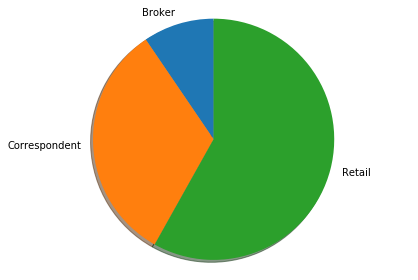

In [9]:
# The pie chart showing the distribution
labels = ["Broker", "Correspondent", "Retail"]
fig1, ax1 = plt.subplots()
ax1.pie(recent_channel_dist["number"], labels=labels, shadow=True, startangle=90)
ax1.axis("equal")
plt.tight_layout()
plt.show()

It is very obvious that retail initializes the majority of the home purchases, while correspondents are also the origin of more than a quarter of the purchases, according to the dataset from Freddie Mac. Broker, however, only brings up less than 10% of the purchases, making it a minority in the origination channel distribution. 

# Analysis on the Monthly Performance Dataset

The Monthly Performance dataset represents the performance of the mortgages being repaid after it has been initialized, on a montly basis. It contains the information including the balance, age, modification history, payment history and delinquency status. By interpreting the dataset, we may be able to analyse the factors of solid performance on payments, as well as to figure out the reasons of delinquency occurring in mortgages. 

In [10]:
# Read the monthly performance csv file
monthly_performance_data = pd.read_csv("update_sample.csv", low_memory=False)

## Loan Age Distribution in Years 2014 to 2019

In this part, I wish to see the distribution of the loan ages between the years 2014 and 2019. Below shows the steps I took to compute this distribution, as well as to visualize it using a histogram. 

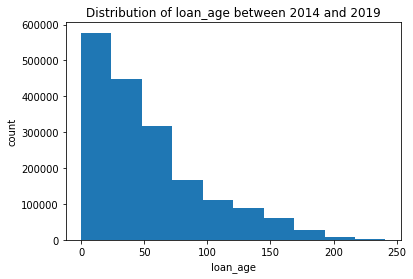

In [11]:
# Distribution of loan ages between 2014 and 2019
recent_performance_data = monthly_performance_data.loc[
    (monthly_performance_data["monthly_reporting_period"] // 100 >= 2014) 
    & (monthly_performance_data["monthly_reporting_period"] // 100 <= 2019)
]
recent_loan_age = recent_performance_data.loc[:, "loan_age"]
plt.hist(recent_loan_age)
plt.xlabel("loan_age")
plt.ylabel("count")
plt.title("Distribution of loan_age between 2014 and 2019")
plt.show()

By observing the histogram above, we can see a very obvious **survival distribution** in the loan ages in the specified 6 years. The reason for it is the cumulative records for each of the mortgages: the same mortgage will make a record each month it is in effect, with the age incremented by a month. Over the years, old mortgages with high loan ages are paid off or terminated, while new mortgages appear in the dataset starting with a clean history (loan age being 0). The fact contributes to the survival distribution as we see in the histogram, with less records surviving in the record as the age increases. 

## Mortgage Fulfillment in 2016

At the time a mortgage is fulfilled (either by prepayment or charging off), it is indicated on the specific record in the Monthly Performance dataset. In specific, it will have a Zero Balance code of 1 representing the very case of successful fulfillment of the mortgage. 

In this part, I picked the year 2016 as an example, and computed the range, as well as then mean and median, of the loan age, months to maturity and current interest rate of the mortgages that are successfully fulfilled in the year. 

In [12]:
# Making a table of the requested values of mortgages with zero-balance code
sixteen_performance_data = monthly_performance_data.loc[
    (monthly_performance_data["monthly_reporting_period"] // 100 == 2016)
    & (monthly_performance_data["zero_balance_code"] == 1)
]
sixteen_performance_output = pd.DataFrame(
    np.array([[0] * 4] * 3)
)
sixteen_performance_output = sixteen_performance_output.rename(
    index={0: "loan_age", 1: "months_to_maturity", 2: "current_interest_rate"}, 
    columns={0: "mean", 1: "min", 2: "median", 3: "max"}
)

sixteen_performance_output["mean"]["loan_age"] = sixteen_performance_data["loan_age"].mean()
sixteen_performance_output["min"]["loan_age"] = sixteen_performance_data["loan_age"].min()
sixteen_performance_output["median"]["loan_age"] = sixteen_performance_data["loan_age"].median()
sixteen_performance_output["max"]["loan_age"] = sixteen_performance_data["loan_age"].max()

sixteen_performance_output["mean"]["months_to_maturity"] \
    = sixteen_performance_data["months_to_maturity"].mean()
sixteen_performance_output["min"]["months_to_maturity"] \
    = sixteen_performance_data["months_to_maturity"].min()
sixteen_performance_output["median"]["months_to_maturity"] \
    = sixteen_performance_data["months_to_maturity"].median()
sixteen_performance_output["max"]["months_to_maturity"] \
    = sixteen_performance_data["months_to_maturity"].max()

sixteen_performance_output["mean"]["current_interest_rate"] \
    = sixteen_performance_data["current_interest_rate"].mean()
sixteen_performance_output["min"]["current_interest_rate"] \
    = sixteen_performance_data["current_interest_rate"].min()
sixteen_performance_output["median"]["current_interest_rate"] \
    = sixteen_performance_data["current_interest_rate"].median()
sixteen_performance_output["max"]["current_interest_rate"] \
    = sixteen_performance_data["current_interest_rate"].max()

sixteen_performance_output

,mean,min,median,max
loan_age,57,0,47,212
months_to_maturity,264,0,292,477
current_interest_rate,4,2,4,8


Observing the statistical values of each of the variables, we can conclude that the distribution of the loan age should be right-skewed, which matches our observation in the previous part. The distribution of the months to maturity, on the other hand, should be left-skewed. 

Because the mean and median of the current interest rate are statiscally equal as shown in the data frame above, I would be convinced that the distribution of the current interst rate is more balanced. Hence, the maximum value (8) is more likely an outlier. 

## Factors for Delinquent on Payment

The Monthly Performance dataset provides us with a resource to study the general characteristics for individuals who tend to fulfill their mortgages, as well as to recognize signs that may lead to delinquency in paying for a mortgage. In this part, I wish to find some of the factors that may highly likely be the sign of a future delinquency according to the records provided in the dataset. 

In the dataset, there is a column `current_lds` that indicates the current delinquency status of a mortgage; where provided, the value 0 stands for a current status or less than 30 days of late payment, while any other value other than 0 stands for an over 30-day delinquency. I benefitted from the value to categorize all records to current mortgages and delinquent ones. 

With the binary categorized data, I decided to construct a **decision tree** model on it. The decision tree model is great in selecting the more significant features that affect the categorization of data; although the model is not necessarily be precisely accurate in predicting new data, it is easy for interpretation and visualization, and is a powerful tool for feature selection and references. 

From the categorized dataset, I selected 200,000 samples to train my decision tree model on. In specific, half of the samples (100,000) are randomly selected from the pool of records with a current status, while the other half are randomly selected from the pool of records with a delinquent status. Because of the significant minority of delinquency records than the current ones, this is the largest possible sample set I can obtain to guarantee a similar quantity for the two target values. 

Next, I randomly selected 80% of the selected sample set to form the training data set, while the remaining 20% serves as the testing data set for the model. Below is the training steps for my decision tree model. 

In [13]:
# Decision tree model
# Categorize the dataset to form the two targets
current_lds_data = monthly_performance_data.loc[
    (monthly_performance_data["current_lds"] != "XX")
]
positive_data = current_lds_data.loc[current_lds_data["current_lds"] == "0"]
negative_data = current_lds_data.loc[current_lds_data["current_lds"] != "0"]

# Selection of the sample data
n_sample = 200000
columns_to_analyse = [
    "current_actual_upb", 
    "loan_age",
    "months_to_maturity",
    "modification_flag",
    "current_interest_rate",
    "current_deffered_upb"
]
sample_data = pd.concat(
    [positive_data.sample(n=n_sample // 2), negative_data.sample(n=(n_sample - n_sample // 2))]
).sample(frac=1)
sample_data = sample_data.replace({"modification_flag": {"Y": 1, np.nan: 0}})

# Select the training and test data sets
training_data, test_data = sample_data[:int(0.8 * n_sample)], sample_data[int(0.8 * n_sample):]
y_train, x_train = np.array(training_data["current_lds"] == "0"), \
    training_data.loc[:, columns_to_analyse]
y_test, x_test = np.array(test_data["current_lds"] == "0"), \
    test_data.loc[:, columns_to_analyse]

# Fit the training data to the decision tree
dt = DecisionTreeClassifier(criterion="gini")
dt.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

After training the decision tree model over my training data set, I used the model to predict my test data set, and evaluates its performance by checking its hit rate. 

In [14]:
# Predict the test data using the trained decision tree
predict_output = dt.predict(x_test)

# Compute the accuracy rate for the prediction
corr = 0
for i in range(0, len(predict_output)):
    if predict_output[i] == y_test[i]:
        corr += 1
acc_rate = corr / len(predict_output)
acc_rate

0.824675

As shown above, the model achieved $\geq$ 80% accuracy when predicting over the test data set. This provides me with the confidence in the model, that the features selected by it should be reasonable and significant for predicting the delinquency status of a mortgage. 

With this is confirmed, I visualize the decision tree in a tree graph. Considering the vast branching factor of the model, I visualized only the top 3 levels of the tree, which displays the most significant factors in the prediction. The graph is demonstrated as seen below. 

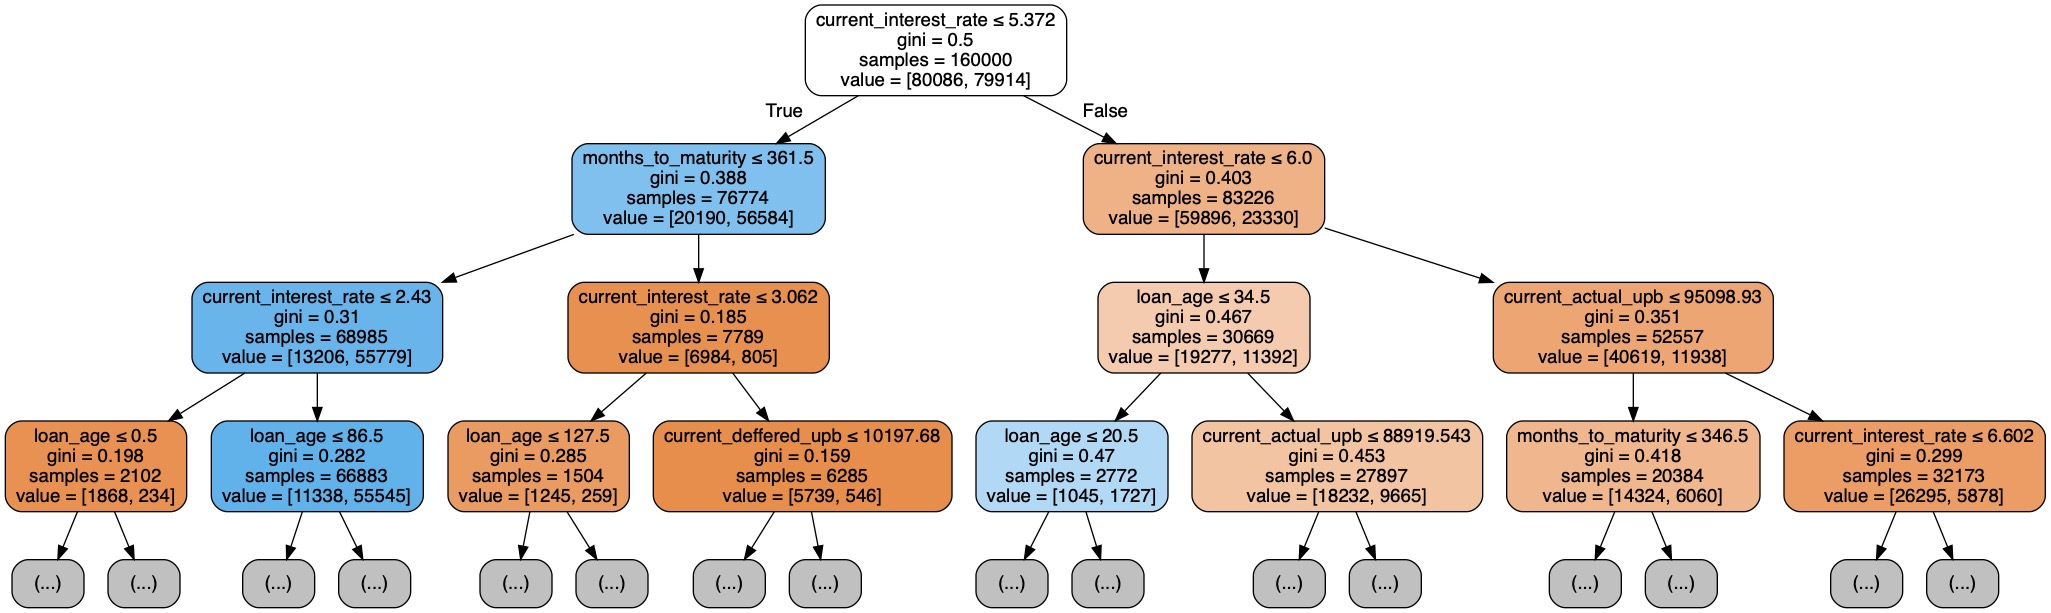

In [15]:
dot_data = StringIO()
export_graphviz(dt, 
                out_file=dot_data, 
                max_depth=3, 
                filled=True, 
                rounded=True,
                feature_names=columns_to_analyse,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_jpg())

By observing the tree graph above, we can see that records with a current status tends to have, in common, lower interest rate; however, if the interest is too low (in specific, lower than 2.5%), there occurs a strong tendency for the mortgage record to develop a delinquency. Current mortgage records also tend to have fewer months to maturity, while records with more than 30 years to maturity are more likely to be delinquent. In addition, records with a delinquent status also tend to have a high interest rate in common. 

From the observation, we can conclude that the risk of delinquency in mortgage payment is higher when: 

- Current interest rate is beyond the 2.5%~5.5% range, or
- Time to legal maturity is over 30 years. 

Again, the conclusions are for reference use only, as decision tree is not regarded as a precise predicting model. However, the feature selection will be useful for conducting further analysis on the problem using more precise techniques like linear regression analysis. 